Build a variational auto-encoder (VAE) to generate digit images from a noise distribution with TensorFlow.

References:
*   Auto-Encoding Variational Bayes The International Conference on Learning Representations (ICLR), Banff, 2014. D.P. Kingma, M. Welling
*   Understanding the difficulty of training deep feedforward neural networks. X Glorot, Y Bengio. Aistats 9, 249-256





    
    


In [0]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("/tmp/data", one_hot=True)

W0822 12:01:56.276243 140022254917504 deprecation.py:323] From <ipython-input-2-4b314b129b7a>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0822 12:01:56.277692 140022254917504 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0822 12:01:56.278812 140022254917504 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruction

Extracting /tmp/data/train-images-idx3-ubyte.gz


W0822 12:01:56.594165 140022254917504 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0822 12:01:56.597446 140022254917504 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0822 12:01:56.645602 140022254917504 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: __init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a f

Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
# training hyperparameters
learning_rate = 0.001
num_steps=30000
batch_size=64

#network hyperparameters
image_dim = 784
hidden_dim=512
latent_dim=2

#custom initialization (Xavier Glorot initialization)
def glorot_init(shape):
  return tf.random_normal(shape=shape, stddev=1./tf.sqrt(shape[0]/2.))

In [0]:
# variables
weights = {
    'encoder_h1':tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean':tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std':tf.Variable(glorot_init([hidden_dim,latent_dim])),
    'decoder_h1':tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out':tf.Variable(glorot_init([hidden_dim, image_dim]))
}

biases={
    'encoder_b1':tf.Variable(glorot_init([hidden_dim])),
    'z_mean':tf.Variable(glorot_init([latent_dim])),
    'z_std':tf.Variable(glorot_init([latent_dim])),
    'decoder_b1':tf.Variable(glorot_init([hidden_dim])),
    'decoder_out':tf.Variable(glorot_init([image_dim]))
}

In [0]:
# build encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1'])+biases['encoder_b1']
encoder = tf.nn.tanh(encoder)

z_mean=tf.matmul(encoder, weights['z_mean'])+biases['z_mean']
z_std=tf.matmul(encoder, weights['z_std'])+biases['z_std']

#sampler: normal random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0.0, stddev=1.0,
                      name='epsilon')
z=z_mean + tf.exp(z_std/2)*eps

#build decoder (with scope to reuse these layers later)
decoder = tf.matmul(z, weights['decoder_h1'])+biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out'])+biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [0]:
# define VAE loss
def vae_loss(x_reconstructed, x_true):
  #reconstructin loss
  encode_decode_loss = x_true*tf.log(1e-10 + x_reconstructed) + (1-x_true)*tf.log(1e-10 +1 -x_reconstructed)
  encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
  
  #KL divergence loss
  kl_div_loss = 1 + z_std - tf.square(z_mean)-tf.exp(z_std)
  kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
  return tf.reduce_mean(encode_decode_loss+kl_div_loss)  

In [7]:
loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

init= tf.global_variables_initializer()

W0822 12:01:57.304488 140022254917504 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/training/rmsprop.py:119: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


step 1 loss 619.30237
step 1000 loss 174.89532
step 2000 loss 169.34435
step 3000 loss 167.05222
step 4000 loss 156.91934
step 5000 loss 159.22395
step 6000 loss 152.03459
step 7000 loss 152.5803
step 8000 loss 141.09497
step 9000 loss 156.0929
step 10000 loss 154.03723
step 11000 loss 145.73256
step 12000 loss 156.07918
step 13000 loss 156.95828
step 14000 loss 149.46347
step 15000 loss 153.22813
step 16000 loss 162.47427
step 17000 loss 151.71367
step 18000 loss 153.00412
step 19000 loss 158.41571
step 20000 loss 155.40442
step 21000 loss 143.2638
step 22000 loss 148.49963
step 23000 loss 159.50171
step 24000 loss 131.0404
step 25000 loss 151.4746
step 26000 loss 145.22913
step 27000 loss 149.60585
step 28000 loss 156.43234
step 29000 loss 151.31409
step 30000 loss 152.16206


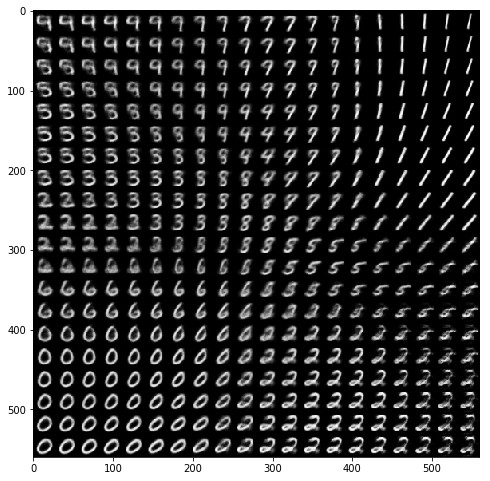

In [11]:
with tf.Session() as sess:
  sess.run(init)
  
  for i in range(1, num_steps+1):
    batch_x, _ = mnist.train.next_batch(batch_size)
    
    #train
    feed_dict = {input_image:batch_x}
    
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i%1000 ==0 or i==1:
      print("step",i, "loss", l)
      
      
  
  #testing 
  #generator takes noise as input
  noise_input=tf.placeholder(tf.float32, shape=[None, latent_dim])

  #rebuild decoder to create image from noise
  decoder = tf.matmul(noise_input, weights['decoder_h1'])+biases['decoder_b1']
  decoder = tf.nn.tanh(decoder)
  decoder = tf.matmul(decoder, weights['decoder_out'])+biases['decoder_out']
  decoder = tf.nn.sigmoid(decoder)

  #build a manifold of generated digits
  n=20
  x_axis = np.linspace(-3,3,n)
  y_axis = np.linspace(-3,3,n)

  canvas = np.empty((28*n, 28*n))

  for i, yi in enumerate(x_axis):
    for j,xi in enumerate(y_axis):
      z_mu=np.array([[xi, yi]]*batch_size)
      x_mean = sess.run(decoder, feed_dict={noise_input:z_mu})
      canvas[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28]= x_mean[0].reshape(28,28)

  plt.figure(figsize=(8,10))
  Xi,Yi = np.meshgrid(x_axis, y_axis)
  plt.imshow(canvas, origin="upper", cmap="gray")
  plt.show()      